# Event Display for primary Geant4 events

Most of the code taken from Pietro DiGangi's event display code for XENON1T and slightly modified. The original code can be found here: https://github.com/XENON1T/MCAnalysisScripts/tree/master/G4EventDisplay

### Imports

In [8]:
from init import *
from networkx_additional import *
from rootIO import *

### Single event selection and event scan
+ The function event_df extracts information of a specific event into a dataframe. It returns the event dataframe and the information of the primary particle in a list [xp_pri, yp_pri, zp_pri, e_pri].
+ events_scan displays the entire event dataframe in HTML table format.

In [9]:
   
def event_df(event):
    '''Returns the event dataframe and the information of the primary particle 
    in a list [xp_pri, yp_pri, zp_pri, e_pri]. The argument is a row
    of the main G4 dataframe, corresponding to a specific eventid.'''
    
    index = event.index[0]
    
    #--- select columns to extract (you can drop or add more variables here) ---
    columns = ['trackid',
               'type',
               'xp',
               'yp',
               'zp',
               'parentid',
               'parenttype',
               'creaproc',
               'ed',
               'edproc',
               'time',
              ]
   
    trackid=[]
    type=[]
    xp=[]
    yp=[]
    zp=[]
    parentid=[]
    parenttype=[]
    creaproc=[]
    ed=[]
    edproc=[]
    time=[]
    table = [trackid,type,xp,yp,zp,parentid,parenttype,creaproc,ed,edproc,time]
    
    #--- extract columns from main G4 dataframe ---
    for i in range(0,len(columns)):
        table[i] = event[columns[i]][index]
        
    #--- make the event dataframe ---
    df = pd.DataFrame(table)
    df = df.transpose()
    df.columns = columns
    
    #--- primary particle information to a list ---
    x = event.xp_pri[index]
    y = event.yp_pri[index]
    z = event.zp_pri[index]
    e = event.e_pri[index]
    type = event.type_pri[index]
    primary = [x,y,z,e,type]
    
    return df, primary  

def event_scan(df, eventid):
    '''Print the event dataframe (analogous to Scan of ROOT tree) in table format'''
    event, primary = event_df(df[df.eventid==eventid])
    display(HTML(event.to_html()))

### Plotting daughter-parent hierarchy
The function draw_hierarchy builds a networkx graph to plot the particles contained in the event with hierarchic structure starting from the primary particle.

It show particles' trackid and type and labels the edge connecting daughter-parent with the physical process occurred (creaproc).

In some events one or more parent particles can be missing from the output G4 tree (because it never entered a sensitive volume, but a doughter did). In this case the hierarchic dependency is broken. Only branches with full dependency up to the primary particle are shown in the graph. A warning message for particles with broken branch is shown.

origin argument: 
It specifies the head of the hierarchy. It is 1 (primary particle) by default. If you want to better visualize the branch from a specific particle of the event, you can pass the trackid of such particle as origin. This will still show as a first branch all the backward chain of particles (you should ignore that). There should be a way to take out that first backward branch... added to the todo list :)

In [10]:
#======================= Utilities for hierarchy graph ============================= 

def get_daughters_trackid(event, parentids):
    '''Returns a trackid list of daughters of a set of parent particles.'''
    event = event[event.parentid.isin(parentids)]
    tracks = list(set(event.trackid)) # trackids present in the event    
    tracks.sort() # sort trackids
    return tracks

def get_parentids(event):
    '''Returns a trackid list of all the parent particles in the event.'''
    tracks = list(set(event.parentid))    
    tracks.sort() # sort trackids
    return tracks


def particles_steps(event):
    '''
    Groups particles in daughter production steps. 
    Returns number of steps, 
    a coefficient to increase hierarchy graph dimensions based on multiplicity of daughter productions,
    the list of particles with valid parent dependency
    '''
 
    ids = get_daughters_trackid(event,parentids=[1]) # get daughters of primary particle  
    particles_by_step=[] # divide particles in hierarchic steps
    particles_by_step.append(ids)    
    all_particles = ids # store id of particles displayed in hierarchy graph
   
    #--- Loop over steps as long as a daughter particle is produced ---
    i=1
    while len(ids)>0:
        ids = get_daughters_trackid(event,parentids = ids)
        if len(ids)>0:
            particles_by_step.append(ids)
            all_particles = all_particles + ids
            i = i+1            
    #print('particles by step:', particles_by_step)
    
    ids = []
    nsteps = i
    multiplicity = 1
    
    step_max = 0
    multiplicity_max = 1
   
    #--- Associate daughter particles to their parent ---
    for n in (range(0,nsteps)):
        set_ids = particles_by_step[n]        
        particles = event[event.trackid.isin(set_ids)]
        parent_ids = get_parentids(particles)
        multiplicity = len(parent_ids) * multiplicity        
        list_=[]
        # collect by parentid
        for parent in parent_ids:
            daughters = get_daughters_trackid(particles,[parent]) # set of daughters of this parent
            list_.append([parent,daughters])
            
            if len(daughters)>=multiplicity_max:
                multiplicity_max=len(daughters)
                step_max = n+2
        
        ids.append(list_)
        
    coefficient = multiplicity_max*step_max
    #print(multiplicity_max, step_max)
        
    return nsteps+1, coefficient, all_particles


#======================= Main function to plot hierarchy graph ============================= 

def draw_hierarchy(df, eventid, particles=[], origin=1):
    '''origin is the top of the hierarchy'''
    event, primary = event_df(df[df.eventid==eventid])
    if len(particles)>0:
        event = event[event.type.isin(particles)]
        
    event = event.sort_values(by=['trackid']) # sort dataframe by trackid
    
    #--- Get info about daughter production steps ---
    nsteps, coeff, all_particles = particles_steps(event)    
    all_particles.append(0)
    all_particles.append(1)
    #print('particles:', all_particles)
    
    #--- Particles without parent + particles not saved in G4 output which produced daughters
    nn = event[~event.trackid.isin(all_particles)]
    missing_parent = list(set(nn.trackid))
    unknowns = set(missing_parent + list(set(nn.parentid)))
    #print('sons of a bitch:', unknowns)
    
   
    #--- figure dimensions ---
    fig, ax = plt.subplots()
    fig.set_figwidth(10+coeff*1.)
    fig.set_figheight(nsteps*3)
    

    #--- graph ---
    g = nx_from_pandas_dataframe(event, source='trackid', target='parentid') 
    #print('nodes:', g.nodes())
    #print('edges:', g.edges())
    
    try: g.remove_node(0) # remove first node for better visualization
    except: pass

    #--- Remove nodes for particles with missing parent ---
    for track in unknowns:
        try: g.remove_node(track)
        except: pass
    
    #print('After removing nodes...')   
    #print('nodes:', g.nodes())
    #print('edges:', g.edges())


    #--- specific attributes for edges (creaproc) ---
    edges = list(g.edges())
    labels_edges = {}

    for i in range(0,len(edges)):
        trackid = edges[i][1]
        particle = event[event.trackid==trackid] # Select steps of a specific particle
        try: 
            creaproc = particle.creaproc[particle.index[0]]
        except:
            creaproc = 'unknown'
        labels_edges[edges[i]] = creaproc

        
    #--- specific attributes for nodes (id, type, color) ---    
    nodes = list(g.nodes())    
    labels_nodes = {}
    node_shape = []
    node_alpha = []
    colors = []
    cmap = cm.nipy_spectral
    for i in range(0,len(nodes)):
        trackid=nodes[i]         
        particle = event[event.trackid==trackid] # Select steps of a specific particle
        try: 
            type = particle.type[particle.index[0]] # Get type of the particle
        except:
            type = '?'
        #type = particle.type[particle.index[0]] # Get type of the particle
        #marker, alpha = get_marker_type_tree(type) # Get marker and alpha for the particle   
        #node_shape.append(marker)
        #node_alpha.append(alpha)
        colors.append(cmap(i/len(nodes)))
        labels_nodes[nodes[i]] = type
        
        labels_nodes[1] = primary[4][0] # (re)assign particle type to primary particle (if missing in G4 output tree)
    labels_nodes = OrderedDict(sorted(labels_nodes.items()))
        
    #--- Defined hierarchic positions ---
    pos = nx_hierarchy_pos(g,origin) 
   
    #print('edges:', g.edges())
    #print('labels-edges:', labels_edges)
    #print('nodes:', g.nodes())
    #print('labels-nodes:', labels_nodes)
    #print('colors:', colors)
    
    #--- Draw graph ---
    nx.draw(g, pos=pos, node_size=1000, with_labels=True, node_color=colors,
            font_color='white', font_size=14, edge_color='gray', width=2, style='solid')
    
    #--- Draw edge labels ---
    nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=labels_edges)
    #--- Draw additional nodes labels ---
    nx_draw_labels(g, pos=pos, labels=labels_nodes, font_color=colors, font_size=14, yoffset=0.033)
    
    plt.draw()
    plt.savefig(_decayname+'_tree.pdf', transparent=True, bbox_inches='tight')
    plt.show()
        
    #--- Warning message about missing particles ---
    if len(missing_parent)>0:
        print('>>> Warning <<<\nSome particles are not displayed in the hierarchy graph because their parent is not saved in the output G4 tree.')
        print('Particles not shown in the hierarchy graph:\n')
        for track in missing_parent:
            particle = event[event.trackid==track]
            _type = list(set(particle.type))[0]
            _id = list(set(particle.trackid))[0]
            _parenttype = list(set(particle.parenttype))[0]
            _parentid = list(set(particle.parentid))[0]
            print('• %s #%d <--- %s #%d (parent)' % (_type, _id, _parenttype, _parentid))

### Load the file and make plots

In [11]:
_files_dir = '/Users/christianwittweg/geant4_workdir/MuensterTPC-MC/example_spectra_decay0/'
_filename = '*_Decay0_Xe124_'
_decayname = '0nukk'
_suffix = '.root'

_file = _files_dir + _filename + _decayname + _suffix


branches=['eventid','trackid','type', 'xp', 'yp', 'zp', 'parentid', 'parenttype', 'creaproc', 'ed', 'edproc', 'time',
         'type_pri', 'e_pri', 'xp_pri', 'yp_pri', 'zp_pri']

df = g4root_to_df(_file,branches,1)

/Users/christianwittweg/geant4_workdir/MuensterTPC-MC/example_spectra_decay0/*_Decay0_Xe124_0nukk.root



/Users/christianwittweg/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/christianwittweg/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/christianwittweg/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/christianwittweg/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be rem

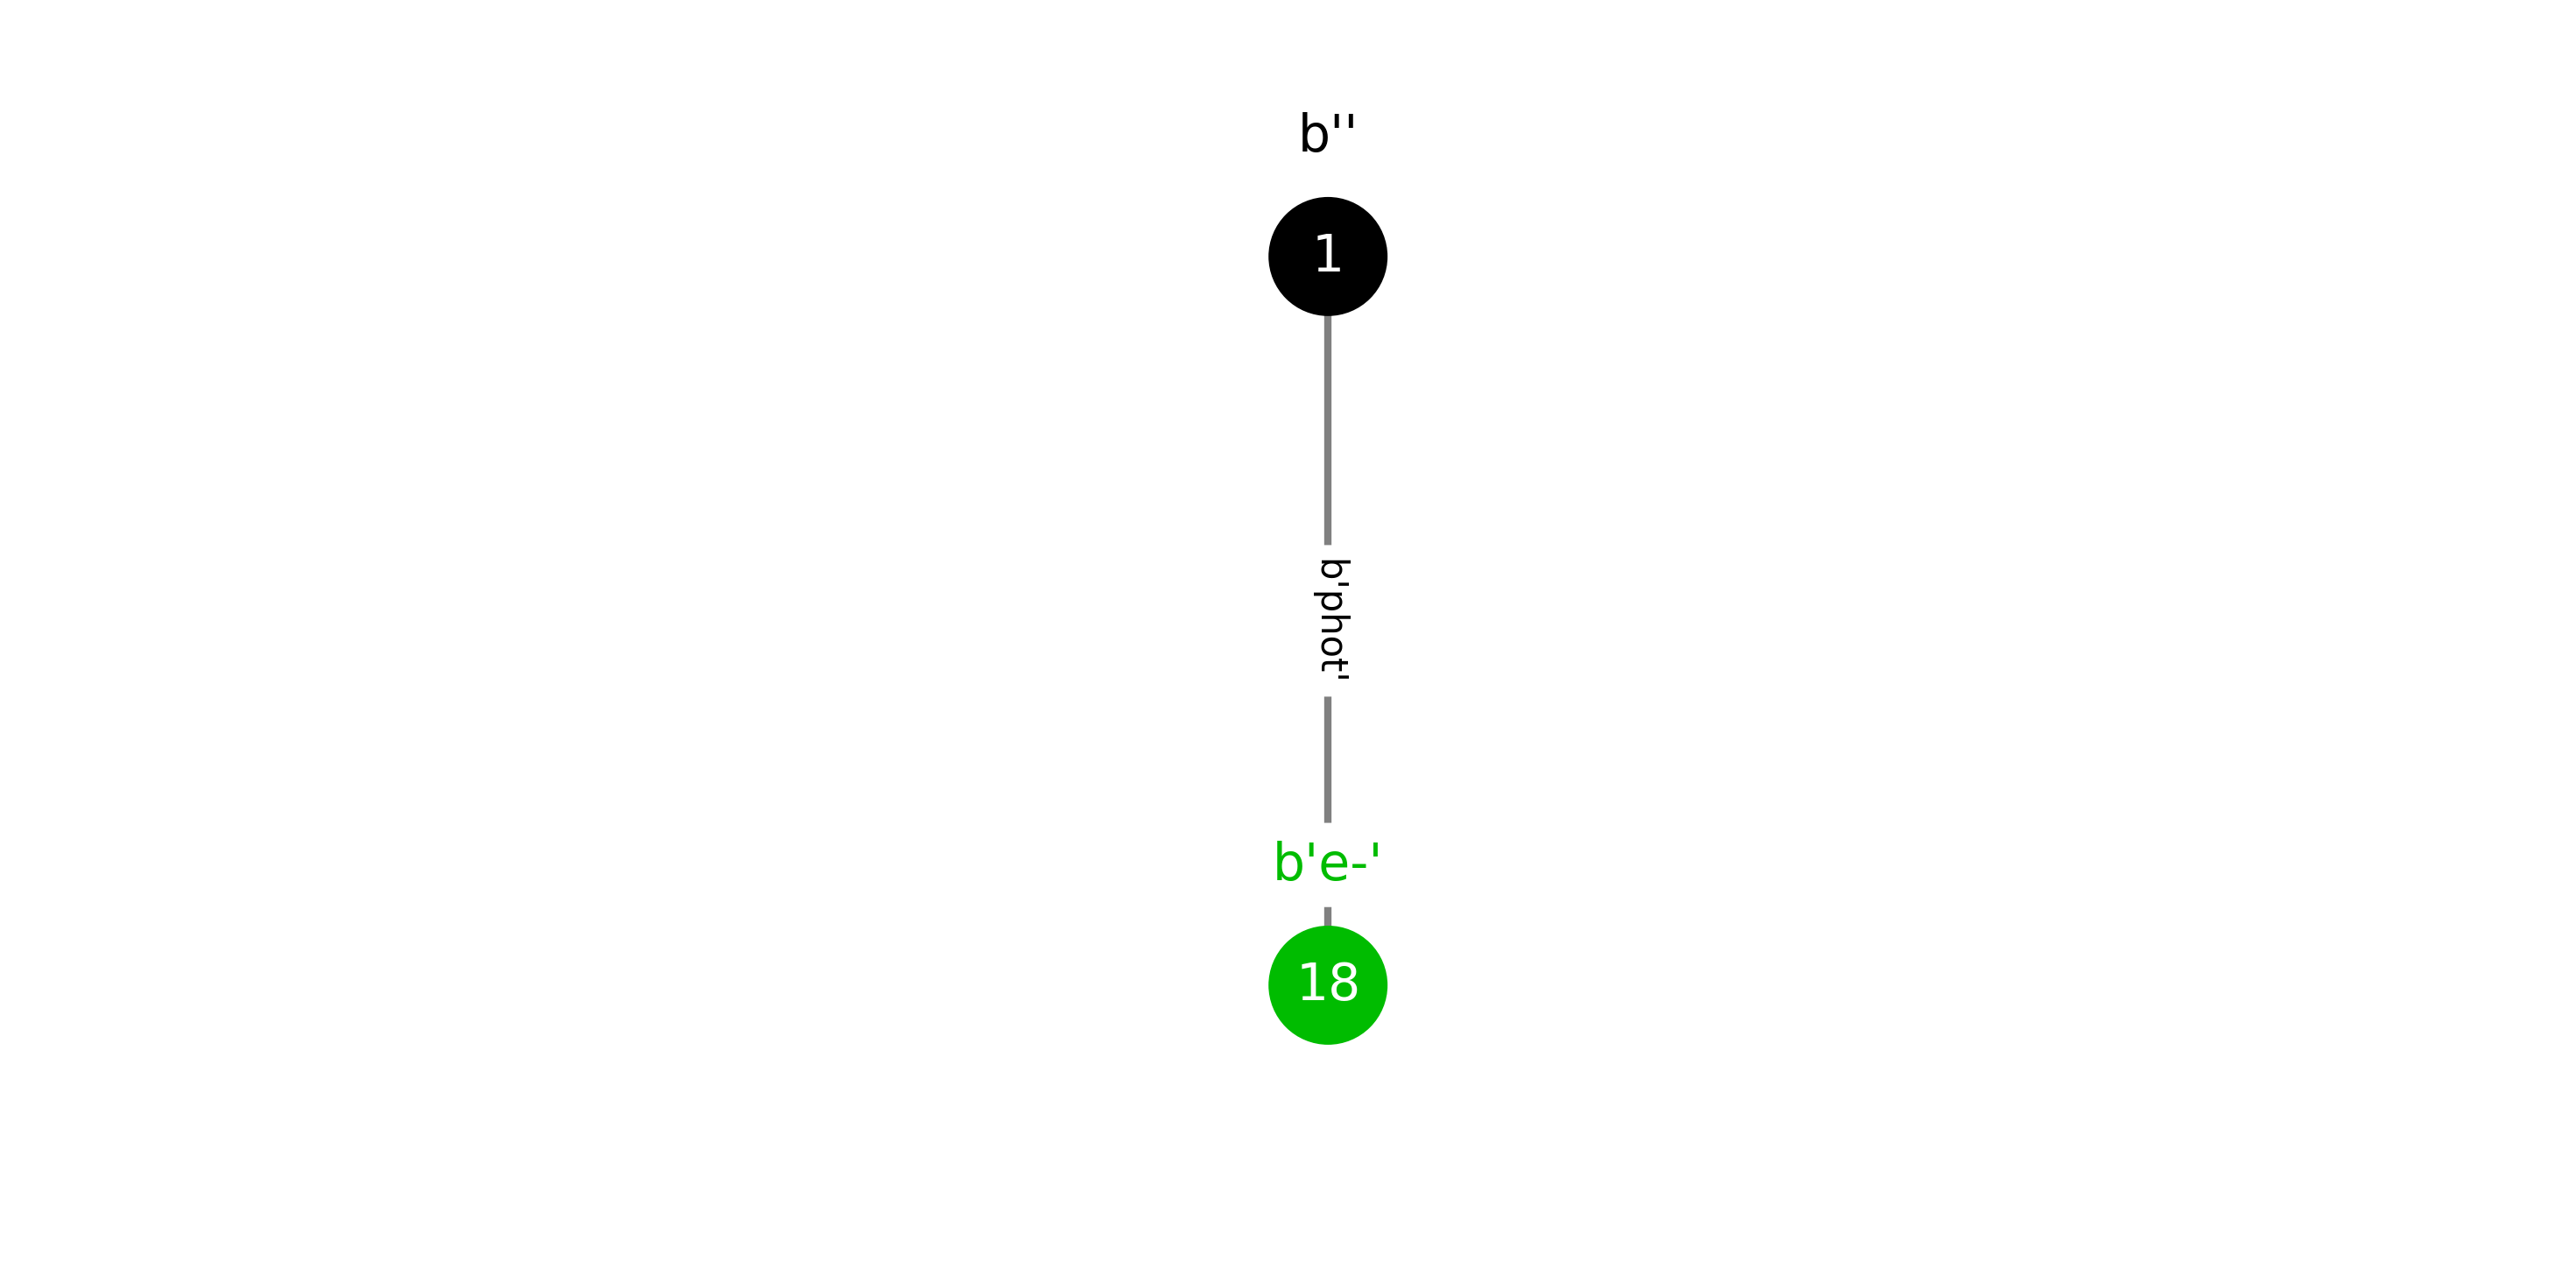

>>> Warning <<<
Some particles are not displayed in the hierarchy graph because their parent is not saved in the output G4 tree.
Particles not shown in the hierarchy graph:

• b'gamma' #2 <--- b'none' #0 (parent)
• b'gamma' #3 <--- b'none' #0 (parent)
• b'gamma' #4 <--- b'none' #0 (parent)
• b'gamma' #5 <--- b'none' #0 (parent)
• b'gamma' #6 <--- b'none' #0 (parent)
• b'e-' #7 <--- b'gamma' #6 (parent)
• b'e-' #8 <--- b'gamma' #6 (parent)
• b'gamma' #9 <--- b'gamma' #6 (parent)
• b'e-' #10 <--- b'gamma' #9 (parent)
• b'e-' #11 <--- b'gamma' #5 (parent)
• b'e+' #12 <--- b'gamma' #5 (parent)
• b'e-' #13 <--- b'gamma' #4 (parent)
• b'e-' #14 <--- b'gamma' #4 (parent)
• b'e-' #15 <--- b'gamma' #4 (parent)
• b'e-' #16 <--- b'gamma' #3 (parent)
• b'e-' #17 <--- b'gamma' #2 (parent)
• b'gamma' #19 <--- b'e-' #13 (parent)
• b'e-' #20 <--- b'gamma' #19 (parent)
• b'gamma' #21 <--- b'gamma' #19 (parent)
• b'e-' #22 <--- b'gamma' #21 (parent)
• b'e-' #23 <--- b'e+' #12 (parent)
• b'gamma' #24 <--

In [12]:
eventid=0
draw_hierarchy(df, eventid)

In [13]:
event_scan(df,eventid)

,trackid,type,xp,yp,zp,parentid,parenttype,creaproc,ed,edproc,time
0,6,b'gamma',54.2138,-96.5914,-72.2821,0,b'none',b'Null',0.98947,b'compt',8.96123e-11
1,6,b'gamma',51.5139,-97.8146,-72.7372,0,b'none',b'Null',4.7747,b'phot',9.96151e-11
2,8,b'e-',51.5026,-97.8278,-72.7539,6,b'gamma',b'phot',86.646,b'eIoni',9.97347e-11
3,8,b'e-',51.4995,-97.8339,-72.7587,6,b'gamma',b'phot',92.4538,b'eIoni',9.97871e-11
4,8,b'e-',51.4995,-97.8339,-72.7587,6,b'gamma',b'phot',0,b'Scintillation',9.97871e-11
5,7,b'e-',54.2592,-96.5407,-72.2426,6,b'gamma',b'compt',103.971,b'eIoni',8.99314e-11
6,7,b'e-',54.254,-96.5251,-72.2892,6,b'gamma',b'compt',85.627,b'eIoni',9.01465e-11
7,7,b'e-',54.2604,-96.5503,-72.278,6,b'gamma',b'compt',197.846,b'eIoni',9.02824e-11
8,7,b'e-',54.2604,-96.5503,-72.278,6,b'gamma',b'compt',0.63785,b'eIoni',9.02829e-11
9,7,b'e-',54.2604,-96.5503,-72.278,6,b'gamma',b'compt',0,b'Scintillation',9.02829e-11
